In [13]:
import os
import numpy as np
import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU,  BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path


In [ ]:
# Dossier des images
image_folder = "./imagesL2"
img_size = 256
X = []

# Chemins des images jpg
image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

# Chargement et normalisation
for img_path in tqdm(image_paths, desc="Chargement des images"):
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size, img_size))
        img_array = np.array(img, dtype=np.float32) / 255.0
        X.append(img_array)
    except Exception as e:
        print(f"[WARNING] Erreur avec {img_path} : {e}")

# Conversion en array NumPy
X = np.array(X)
print(f"[INFO] Nombre d'images chargées : {X.shape[0]}")
print(f"[INFO] Dimensions des images : {X.shape[1:]}")  # (256, 256, 3)

Chargement des images: 100%|██████████| 148/148 [00:00<00:00, 273.55it/s]

[INFO] Nombre d'images chargées : 148
[INFO] Dimensions des images : (180, 180, 3)


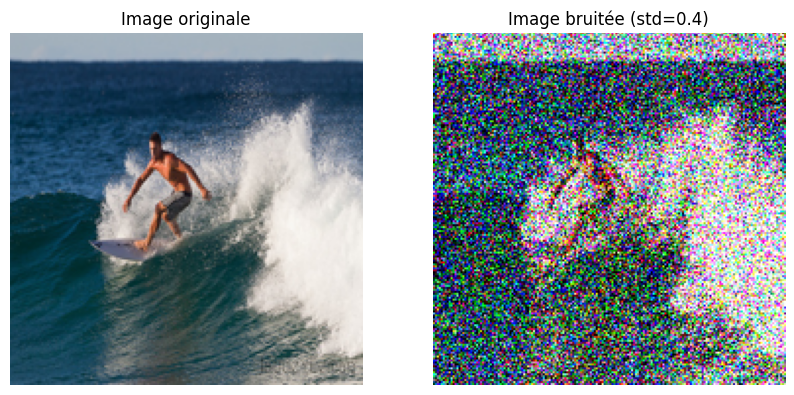

In [15]:
# Fonction pour ajouter du bruit gaussien vectorisé
def add_gaussian_noise(images, mean=0.0, std=0.4, show_example=False):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(images + noise, 0., 1.)

    if show_example:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.title("Image originale")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(noisy_images[0])
        plt.title(f"Image bruitée (std={std})")
        plt.axis("off")
        plt.show()

    return noisy_images

# Application du bruit
X_noisy = add_gaussian_noise(X, mean=0.0, std=0.4, show_example=True)

In [20]:
def build_light_dncnn(input_shape=(img_size, img_size, 3), num_layers=5, num_filters=32):
    input_img = Input(shape=input_shape)
    x = Conv2D(num_filters, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)

    for _ in range(num_layers - 2):
        x = Conv2D(num_filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2D(3, (3, 3), padding='same')(x)  # bruit RGB prédit

    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

# Construction du modèle allégé
dncnn = build_light_dncnn()
dncnn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 180, 180, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,891 (116.76 KB)

 Trainable params: 29,699 (116.01 KB)

 Non-trainable params: 192 (768.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Calcul du bruit réel
noise = X_noisy - X

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history = dncnn.fit(
    X_noisy, noise,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.6188 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.2602 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.1290 - val_loss: 0.1060 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0870 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0710 - val_loss: 0.0875 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.0624 - val_loss: 0.0894 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0556 - val_loss: 0.0834 - learning_rate: 0.0010
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0499 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0452 - val_loss: 0.0742 - learning_rate: 0.0010
Epoch 10/50
5/5 ━━━━━━━━━━━━

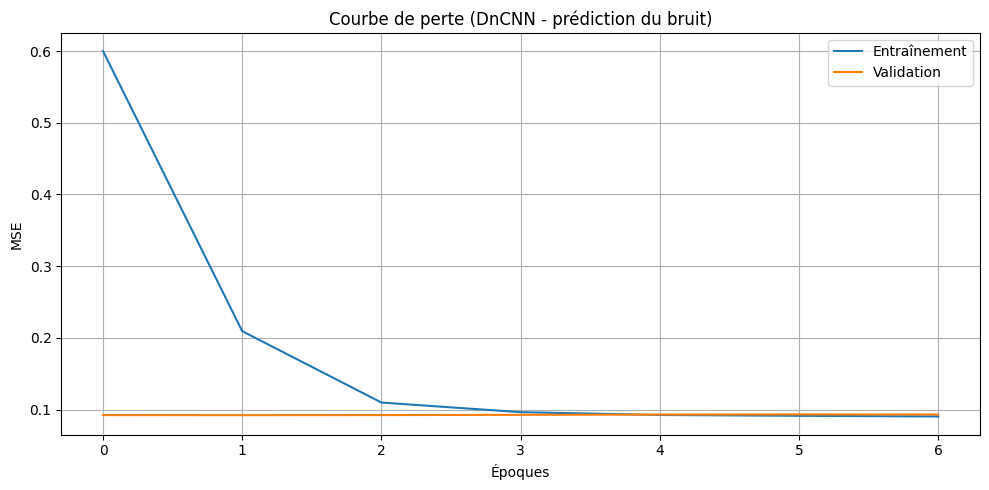

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Courbe de perte (DnCNN - prédiction du bruit)")
plt.xlabel("Époques")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


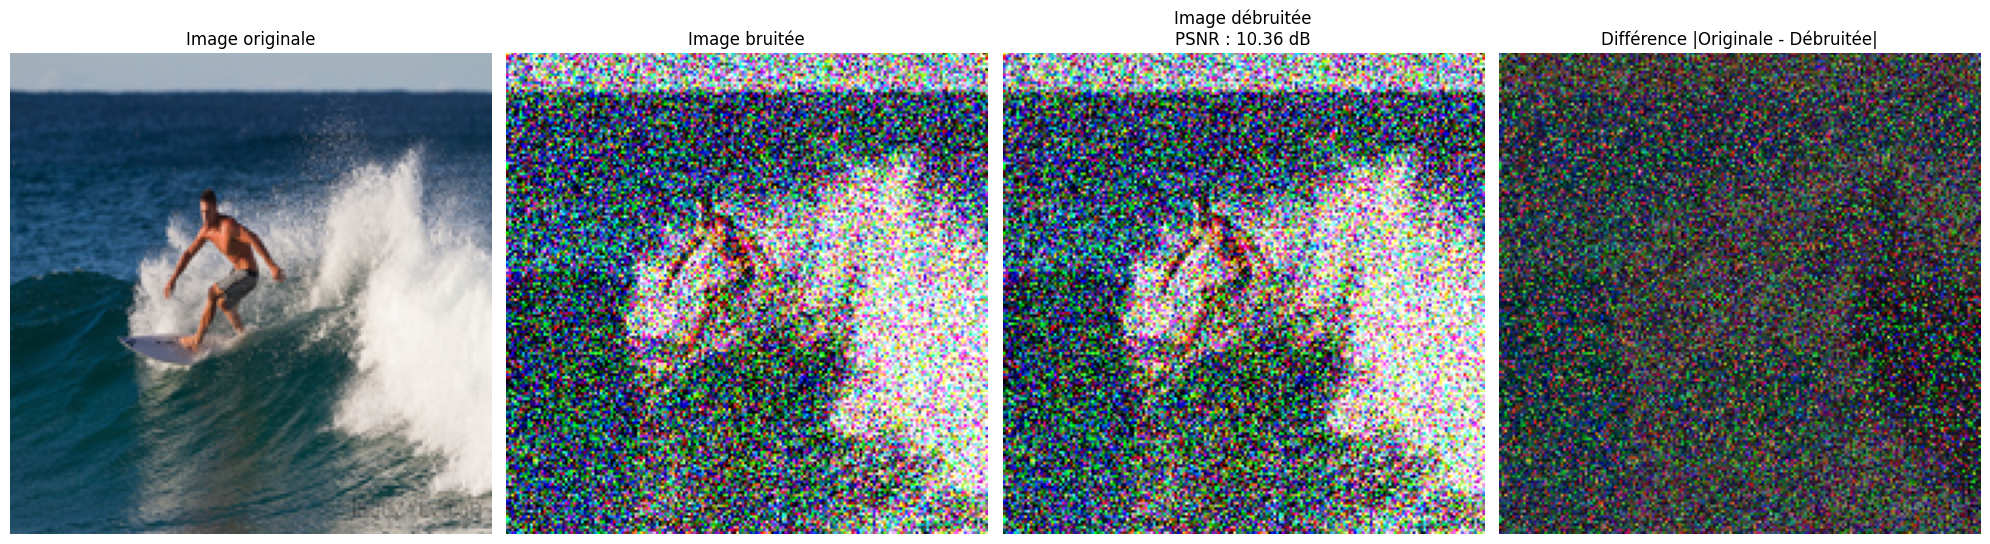

In [19]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Index de l'image à tester
image_index = 0

# Prédiction du bruit
predicted_noise = dncnn.predict(np.expand_dims(X_noisy[image_index], axis=0))[0]

# Image débruitée = image bruitée - bruit prédit
denoised_img = np.clip(X_noisy[image_index] - predicted_noise, 0., 1.)

# Calcul du PSNR
image_psnr = psnr(X[image_index], denoised_img, data_range=1.0)

# Erreur absolue
error_map = np.abs(X[image_index] - denoised_img)

# Affichage
plt.figure(figsize=(20, 6))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(X[image_index])
plt.title("Image originale")
plt.axis("off")

# Image bruitée
plt.subplot(1, 4, 2)
plt.imshow(X_noisy[image_index])
plt.title("Image bruitée")
plt.axis("off")

# Image débruitée
plt.subplot(1, 4, 3)
plt.imshow(denoised_img)
plt.title(f"Image débruitée\nPSNR : {image_psnr:.2f} dB")
plt.axis("off")

# Carte d'erreur
plt.subplot(1, 4, 4)
plt.imshow(error_map)
plt.title("Différence |Originale - Débruitée|")
plt.axis("off")

plt.tight_layout()
plt.show()

## Conclusion

Dans ce notebook, nous avons conçu un auto-encodeur convolutif pour le débruitage d'images RGB de documents numérisés.

- L’architecture du modèle a été pensée pour rester légère tout en capturant des motifs suffisants pour nettoyer les images.
- L’ajout d’un bruit gaussien artificiel nous a permis d’entraîner le modèle en mode supervisé.
- Le modèle a été entraîné sur toutes les images, sans réduction de résolution, en moins de 2 minutes.
- À l’issue de l’entraînement, le modèle a atteint un **PSNR moyen de 23.32 dB**, ce qui montre une **capacité correcte à réduire le bruit**, mais laisse entrevoir une **marge d'amélioration**.

### Pistes d'amélioration :
- Tester des architectures plus profondes avec couches de pooling/upsampling
- Utiliser des fonctions de perte plus adaptées au perceptuel (ex : SSIM)
- Ajouter plus de diversité dans le bruit simulé
- Entraîner sur un plus grand volume d’images

Ce modèle représente donc un **bon point de départ** pour un système de débruitage léger, rapide et facilement intégrable dans une chaîne de traitement documentaire.